# UniAD数据分析

使用`pickle`分析UniAD的测试数据

result.pkl是一个pickle文件, 包含了一个字典, 其中包含了UniAD的评估数据

- 'bbox_results': 感知bbox的评估数据
- 'occ_results_computed': 预测Occ的评估数据
- 'planning_results_computed': 规划结果相关

In [ ]:
from tools.data_analyze.analyze_eval_data import DataAnalyze

In [2]:
file_path = "/home2/lixiang/UniAD_demo/experiments/origin/stage2/origin/test/11071146.pkl"

# 创建 DataAnalyze 实例
data_analyze = DataAnalyze(file_path)
data_analyze.load_data()

数据加载成功！


In [3]:
data_analyze.show_keys()

数据的key：
bbox keys:  dict_keys(['token', 'track_bbox_results', 'boxes_3d', 'scores_3d', 'labels_3d', 'track_scores', 'track_ids', 'sdc_boxes_3d', 'sdc_scores_3d', 'sdc_track_scores', 'sdc_track_bbox_results', 'boxes_3d_det', 'scores_3d_det', 'labels_3d_det', 'traj_0', 'traj_scores_0', 'traj_1', 'traj_scores_1', 'traj', 'traj_scores', 'ret_iou', 'planning_traj', 'planning_traj_gt', 'command'])
occ keys:  dict_keys(['pq', 'sq', 'rq', 'denominator', 'iou', 'num_occ', 'ratio_occ'])
planning keys:  dict_keys(['obj_col', 'obj_box_col', 'L2'])


## bbox结果分析 感知预测结果和规划的实际结果都在里面

bbox是一个list,包含每一帧的感知结果，用`token`来标识每一帧, 每个元素是一个dict, 包含以下字段: 
- token
- 'track_bbox_results', 'boxes_3d', 'scores_3d', 'labels_3d', 'track_scores', 'track_ids': 每一帧感知到的agent的box和得分和分类，太多，不详细描述
- 'sdc_boxes_3d', 'sdc_scores_3d', 'sdc_track_scores', 'sdc_track_bbox_results': 每一帧感知到的自车的box和得分和分类画图解析
- traj, traj_score: 预测轨迹traj形如`[agent_num, traj_num, 12, 5]` 记录agent_num个agent的traj_num个预测的未来12步(6s)的轨迹, traj_score是对应的得分
- planning_traj, planning_traj_score: 规划的轨迹，形如`[1, 6, 2]` 记录规划的未来6步(3s)的轨迹，planning_traj_score是对应的得分

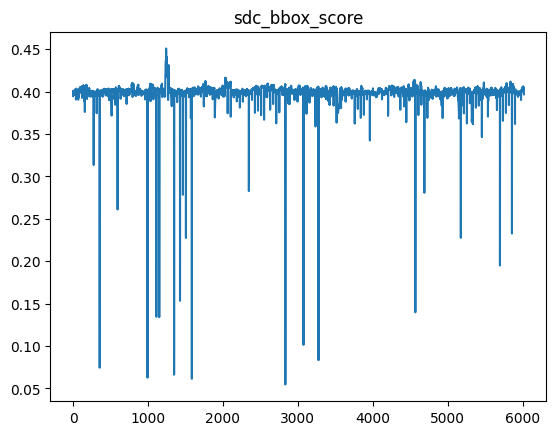

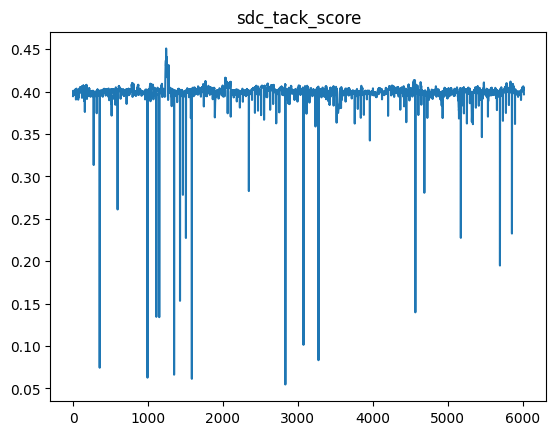

In [4]:
sdc_track_score = data_analyze.analyze_sdc_track()

## Occ

总体Occ的评估结果, 包含以下字段:

每项一般有2个值，第一项`-n`表示近距离(30m x 30m)的评估结果，第二项`-f`表示远距离(50m x 50m)的评估结果

- pq (Panoptic Quality): 表示全景质量，结合了分割质量（精确度）和识别能力（召回率）**越大越好** (**论文中用这个指标对比**)
- sq (Segmentation Quality): 表示分割质量，通常衡量模型在分割过程中对边界细节的把握情况。**越大越好**
- rq (Recognition Quality): 表示识别质量，通常衡量模型在识别过程中对类别的识别准确率。**越大越好**
- denominator: 标准化的分母，用于计算pq, sq, rq
- iou (Intersection over Union): 是一种衡量预测分割和真实分割区域之间重叠程度的指标,越高的值表示预测和真实区域的重叠程度越高，即分割结果越准确. **越大越好**。(**论文中用这个指标对比**)
- num_occ: 预测的occ数量，统计值
- ratio_occ: 表示区域的占据比率，即预测的occ数量占总区域的比率。**评估场景密集程度**


In [5]:
data_analyze.analyze_occ()  # 分析 Occ 数据


OCC 表格(越大越好)：
                       pq         sq         rq  denominator        iou  \
-n (30m x 30m)  55.176485  75.822878  72.770232    9501550.0  63.808119   
-f (50m x 50m)  34.161365  70.894837  48.185974   33389800.0  40.533423   

                num_occ  ratio_occ  
-n (30m x 30m)     1705    0.28327  
-f (50m x 50m)     1705    0.28327  


## Planning

均为规划**未来6步，每步0.5s，共3s**的规划结果

- obj_col: 和障碍物实体的碰撞率
- obj_box: 和障碍物bbox的碰撞率：一般取这个
- L2: 和真实轨迹的L2距离

In [6]:
data_analyze.analyze_planning()  # 分析 Planning 数据

Planning 数据分析：
obj_col: tensor([0.0000, 0.0000, 0.0003, 0.0003, 0.0007, 0.0010], device='cuda:0')
obj_box_col: tensor([0.0003, 0.0010, 0.0013, 0.0015, 0.0030, 0.0061], device='cuda:0')
L2: tensor([0.3355, 0.5072, 0.7193, 0.9824, 1.2903, 1.6498], device='cuda:0')

规划结果：
                    0.5s      1.0s      1.5s      2.0s      2.5s      3.0s  \
obj_col(%)      0.000000  0.000000  0.033217  0.033217  0.066434  0.099651   
obj_box_col(%)  0.033217  0.099651  0.132868  0.149477  0.298954  0.614516   
L2(m)           0.335543  0.507160  0.719288  0.982400  1.290323  1.649800   

                avg_0.5s    avg_1s  
obj_col(%)      0.038753  0.044289  
obj_box_col(%)  0.221447  0.287881  
L2(m)           0.914086  1.046453  


## Track

Track 的都需要从json文件中读取

In [7]:
json_path = "/home2/lixiang/UniAD_demo/test/base_e2e/Thu_Nov__7_12_32_41_2024"

import json
import pandas as pd

In [8]:

track_path = json_path + "/track/metrics_summary.json"

print("Reading result from: ", track_path)

with open(track_path, 'r') as f:
    json_track = json.load(f)

Reading result from:  /home2/lixiang/UniAD_demo/test/base_e2e/Thu_Nov__7_12_32_41_2024/track/metrics_summary.json


In [9]:
print("评估用时: ", json_track['eval_time'], "s")

print("使用传感器 ", json_track['meta'])

# 从cfg中获取class名字
track_cfg = json_track['cfg']
tracking_names = track_cfg['tracking_names']

# 从metrics_summary中获取数据创建表格
track_data = json_track['label_metrics']

print("各类agent的track result: ")
track_df = pd.DataFrame(track_data, index=tracking_names)
# 将列标签转换为大写
track_df.columns = track_df.columns.str.upper()

print(track_df, "\n")

print("自车的track结果(论文中评价指标): ")
# tracking_names中提取track_df列tag作为key绘制pandas表格
track_result_list = track_df.columns.str.lower()

track_reslut = {}
for tag in track_result_list:
    track_reslut[tag] = json_track[tag]

track_reslut_df = pd.DataFrame(track_reslut, index={'tracking_result'})
print(track_reslut_df, "\n")    

评估用时:  2058.7900445461273 s
使用传感器  {'use_lidar': False, 'use_camera': True, 'use_radar': False, 'use_map': False, 'use_external': True}
各类agent的track result: 
               AMOTA     AMOTP    RECALL     MOTAR       GT      MOTA  \
bicycle     0.345881  1.388207  0.417461  0.731946   1993.0  0.300050   
bus         0.433074  1.239388  0.517992  0.715731   2112.0  0.368371   
car         0.578219  0.973955  0.649896  0.741318  58317.0  0.475487   
motorcycle  0.367031  1.394494  0.486090  0.746725   1977.0  0.345979   
pedestrian  0.412099  1.274004  0.473548  0.731089  25423.0  0.335680   
trailer     0.026651  1.767665  0.167010  0.345865   2425.0  0.056907   
truck       0.363261  1.327544  0.529430  0.513903   9650.0  0.270052   

                MOTP      MT      ML         FAF       TP      FP       FN  \
bicycle     0.555324    32.0    75.0   15.835141    817.0   219.0   1161.0   
bus         0.702038    33.0    50.0   20.104099   1087.0   309.0   1018.0   
car         0.547774  

Map和Motion的都要从log的最后一行中读取，把他存到一个字典中

In [53]:
log_path = '/home2/lixiang/UniAD_demo/experiments/origin/stage2/origin/test/logs/eval.11071146'

# 把log的最后一行读出来
with open(log_path, 'r') as f:
    lines = f.readlines()
    last_line = lines[-1]

# 处理掉nan的情况
if 'nan' in last_line:
    last_line = last_line.replace('nan', '0.0')

# 转换为字典
last_line_dict = eval(last_line)
print(last_line_dict.keys())



    

dict_keys(['pts_bbox_NuScenes/car_AP_dist_0.5', 'pts_bbox_NuScenes/car_AP_dist_1.0', 'pts_bbox_NuScenes/car_AP_dist_2.0', 'pts_bbox_NuScenes/car_AP_dist_4.0', 'pts_bbox_NuScenes/car_trans_err', 'pts_bbox_NuScenes/car_scale_err', 'pts_bbox_NuScenes/car_orient_err', 'pts_bbox_NuScenes/car_vel_err', 'pts_bbox_NuScenes/car_attr_err', 'pts_bbox_NuScenes/mATE', 'pts_bbox_NuScenes/mASE', 'pts_bbox_NuScenes/mAOE', 'pts_bbox_NuScenes/mAVE', 'pts_bbox_NuScenes/mAAE', 'pts_bbox_NuScenes/truck_AP_dist_0.5', 'pts_bbox_NuScenes/truck_AP_dist_1.0', 'pts_bbox_NuScenes/truck_AP_dist_2.0', 'pts_bbox_NuScenes/truck_AP_dist_4.0', 'pts_bbox_NuScenes/truck_trans_err', 'pts_bbox_NuScenes/truck_scale_err', 'pts_bbox_NuScenes/truck_orient_err', 'pts_bbox_NuScenes/truck_vel_err', 'pts_bbox_NuScenes/truck_attr_err', 'pts_bbox_NuScenes/construction_vehicle_AP_dist_0.5', 'pts_bbox_NuScenes/construction_vehicle_AP_dist_1.0', 'pts_bbox_NuScenes/construction_vehicle_AP_dist_2.0', 'pts_bbox_NuScenes/construction_vehic

## Map

In [52]:
map_keys = ['lanes_iou', 'drivable_iou', 'divider_iou', 'crossing_iou']

# 从last_line_dict读取数据，转换为pandas表格
map_data = {}
for key in map_keys:
    map_data[key] = last_line_dict[key]

map_df = pd.DataFrame(map_data, index={'map_result'})
print("Map结果: ")
print(map_df)

Map结果: 
            lanes_iou  drivable_iou  divider_iou  crossing_iou
map_result   0.313147      0.691659     0.259437      0.143635


## Motion

In [74]:
import re
# 使用正则表达式提取表格中的数据
# 将 lines 合并为一个单一字符串
log_data = "\n".join(lines)

data_dict = {}

pattern = r"\| *([\w\s]+) *\| *([\d\.]+) *\| *([\d\.]+) *\| *([\d\.]+) *\|"
matches = re.findall(pattern, log_data)

# 提取数据
data = [{'class_name': match[0].strip(), 'min_ADE(m)↓': match[1], 'min_FDE(m)↓': match[2], 'miss_rate↓': match[3]} for match in matches]
# 查找并打印 "car" 这一行的数据
data_dict['car'] = next(item for item in data if item['class_name'] == 'car')
print(data_dict)

# 使用正则表达式提取所有 "EPA vehicle value" 的数据
pattern_EPA = r"EPA\s+(\w+)\s+([\d\.]+)"
matches_EPA = re.findall(pattern_EPA, log_data)

# 获取第一个 "car" 的数据
for match in matches_EPA:
    vehicle, value = match
    if vehicle == 'car':
        data_dict['car']['EPA↑'] = float(value)
        break  # 找到第一个匹配后立即停止循环
# 提取数据
data = [{'class_name': match[0].strip(), 'min_ADE(m)↓': match[1], 'min_FDE(m)↓': match[2], 'miss_rate↓': match[3]} for match in matches]
# 查找并打印 "pedestrian" 这一行的数据
data_dict['pedestrian'] = next(item for item in data if item['class_name'] == 'pedestrian')


# 获取第一个 "pedestrian" 的数据
for match in matches_EPA:
    vehicle, value = match
    if vehicle == 'pedestrian':
        data_dict['pedestrian']['EPA↑'] = float(value)
        break  # 找到第一个匹配后立即停止循环


# 输出 car 的数据
print(data_dict)

# 从data_dict读取数据，转换为pandas表格，忽略到dict的最外层key

data_df = pd.DataFrame(data_dict).T
print("Car和Pedestrian的结果: ")
print(data_df)



{'car': {'class_name': 'car', 'min_ADE(m)↓': '0.7049', 'min_FDE(m)↓': '1.0148', 'miss_rate↓': '0.1497'}}
{'car': {'class_name': 'car', 'min_ADE(m)↓': '0.7049', 'min_FDE(m)↓': '1.0148', 'miss_rate↓': '0.1497', 'EPA↑': 0.4596464044960786}, 'pedestrian': {'class_name': 'pedestrian', 'min_ADE(m)↓': '0.7823', 'min_FDE(m)↓': '1.0499', 'miss_rate↓': '0.1241', 'EPA↑': 0.3528297870839022}}
Car和Pedestrian的结果: 
            class_name min_ADE(m)↓ min_FDE(m)↓ miss_rate↓      EPA↑
car                car      0.7049      1.0148     0.1497  0.459646
pedestrian  pedestrian      0.7823      1.0499     0.1241   0.35283
